In [1]:
import yaml
import umap

import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from math import floor
from scipy.stats import mannwhitneyu

from carot.utils import get_source_target_transport, score_transports_and_targets_combinations
from cmonge.utils import load_config
from carot.trainers.conditional_monge_trainer import ConditionalMongeTrainer
from carot.datasets.conditional_loader import ConditionalDataModule

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set(font="Arial")
sns.set_context("paper")
sns.set_style("whitegrid")
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['ytick.left'] = True
mpl.rcParams['xtick.bottom'] = True

In [3]:
default_colors = {
    "indigo": "#332288",
    "cyan": "#88CCEE",
    "teal": "#44AA99",
    "green": "#117733",
    "olive": "#999933",
    "sand": "#DDCC77",
    "rose": "#CC6677",
    "wine": "#882255",
    "purple": "#AA4499",
    "grey": "#DDDDDD",
}

eval_setting_map = {
    "identity": default_colors["wine"],
    "CAROT": default_colors["cyan"],
    "conCAROT": default_colors["indigo"],
    "conCAROT-OOD": default_colors["indigo"],
    "within condition": default_colors["green"],
    "chemCPA": default_colors["sand"]
}

geneset_map = {
    "functional": default_colors["olive"],
    "functional+score": default_colors["rose"],
    "HVG": default_colors["teal"],
    "random": default_colors["sand"],
}

subset_map = {
    "CD4": default_colors["teal"],
    "CD8": default_colors["purple"],
}

ot_map = {
    "source": default_colors["cyan"],
    "target": default_colors["sand"],
    "transport": default_colors["rose"],
    "rest": default_colors["grey"]
}

cond_ood_comp = {
    "CAROT": default_colors["cyan"],
    "conCAROT": default_colors["indigo"],
    "conCAROT-OOD": default_colors["teal"],
    "chemCPA-OOD": default_colors["sand"],
    "avg CAR": default_colors["rose"]
}

In [4]:
features = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/functional_and_score_genes.txt"
base_fig_save = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Figures/cmonge/ood/CTLA4_"


# CTLA4 - CD4 - OOD

In [5]:
logger_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge_ood/sel_CARs_ood/"
all_mean_metrics=[]
for subset in ["CD4"]:
    for setting in ["identity", "cmonge", "within condition"]:
        with open(f"{logger_path}model_sel_cars_{subset}_{setting}_small_CARs_eval.yaml",) as stream:
            logs = yaml.safe_load(stream)
            
        for i in range(len(logs["experiments"])):
            for condition, results in logs["experiments"][i]["valid-set"].items():
                res = pd.Series(results["mean_statistics"])
                res = res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
                res["eval_car"] = condition
                res["eval_setting"] = setting
                res["subset"] = subset
                all_mean_metrics.append(res)

In [6]:
OOD_res = pd.concat(all_mean_metrics).reset_index(drop=True)
OOD_res = OOD_res[~OOD_res["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]
OOD_res["eval_setting"] = ["conCAROT-OOD" if "cmonge" in s else s for s in OOD_res["eval_setting"]]

In [7]:
OOD_res["CTLA4"] = ["CTLA4" in car for car in OOD_res["eval_car"]]
ood_scores = OOD_res[(OOD_res["CTLA4"])&(OOD_res["eval_setting"]=="conCAROT-OOD")]
ood_scores

,metric,score,eval_car,eval_setting,subset,CTLA4
84,mean_wasserstein,5.763721,41BB-CTLA4-z,conCAROT-OOD,CD4,True
85,mean_mmd,0.065441,41BB-CTLA4-z,conCAROT-OOD,CD4,True
86,mean_sinkhorn div,5.415973,41BB-CTLA4-z,conCAROT-OOD,CD4,True
87,mean_monge_gap,7.318514,41BB-CTLA4-z,conCAROT-OOD,CD4,True
88,mean_drug_signature,1.497011,41BB-CTLA4-z,conCAROT-OOD,CD4,True
89,mean_r2,0.901292,41BB-CTLA4-z,conCAROT-OOD,CD4,True
96,mean_wasserstein,5.812167,CD28-CTLA4-z,conCAROT-OOD,CD4,True
97,mean_mmd,0.072785,CD28-CTLA4-z,conCAROT-OOD,CD4,True
98,mean_sinkhorn div,5.480000,CD28-CTLA4-z,conCAROT-OOD,CD4,True
99,mean_monge_gap,7.002705,CD28-CTLA4-z,conCAROT-OOD,CD4,True


In [8]:
ood_scores[ood_scores["metric"]=="mean_mmd"]

,metric,score,eval_car,eval_setting,subset,CTLA4
85,mean_mmd,0.065441,41BB-CTLA4-z,conCAROT-OOD,CD4,True
97,mean_mmd,0.072785,CD28-CTLA4-z,conCAROT-OOD,CD4,True
121,mean_mmd,0.062945,CD40-CTLA4-z,conCAROT-OOD,CD4,True
127,mean_mmd,0.081448,CTLA4-41BB-z,conCAROT-OOD,CD4,True
133,mean_mmd,0.049400,CTLA4-CD28-z,conCAROT-OOD,CD4,True
139,mean_mmd,0.085656,CTLA4-CD40-z,conCAROT-OOD,CD4,True
145,mean_mmd,0.072109,CTLA4-CTLA4-z,conCAROT-OOD,CD4,True
151,mean_mmd,0.089685,CTLA4-IL15RA-z,conCAROT-OOD,CD4,True
157,mean_mmd,0.084933,CTLA4-NA-z,conCAROT-OOD,CD4,True
163,mean_mmd,0.047744,IL15RA-CTLA4-z,conCAROT-OOD,CD4,True


### avg CAR

In [9]:
# avgerage CAR model
logger_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge_ood/sel_CARs_ood/"
all_mean_metrics = []

with open(f"{logger_path}model_sel_cars_CD4_avg_CAR_OOD_CARs_eval.yaml",) as stream:
        logs = yaml.safe_load(stream)
        
for i in range(len(logs["experiments"])):
    for condition, results in logs["experiments"][i]["valid-set"].items():
        if "CTLA4" not in condition:
            continue
        res = pd.Series(results["mean_statistics"])
        res = res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
        res["eval_car"] = condition
        res["eval_setting"] = "avg CAR"
        res["subset"] = "CD4"
        all_mean_metrics.append(res)
avg_CAR_res = pd.concat(all_mean_metrics).reset_index(drop=True)
avg_CAR_res

,metric,score,eval_car,eval_setting,subset
0,mean_wasserstein,6.501269,41BB-CTLA4-z,avg CAR,CD4
1,mean_mmd,0.024311,41BB-CTLA4-z,avg CAR,CD4
2,mean_sinkhorn div,6.037186,41BB-CTLA4-z,avg CAR,CD4
3,mean_monge_gap,11.527459,41BB-CTLA4-z,avg CAR,CD4
4,mean_drug_signature,1.420583,41BB-CTLA4-z,avg CAR,CD4
5,mean_r2,0.906572,41BB-CTLA4-z,avg CAR,CD4
6,mean_wasserstein,6.341324,CD28-CTLA4-z,avg CAR,CD4
7,mean_mmd,0.022263,CD28-CTLA4-z,avg CAR,CD4
8,mean_sinkhorn div,5.883896,CD28-CTLA4-z,avg CAR,CD4
9,mean_monge_gap,11.558565,CD28-CTLA4-z,avg CAR,CD4


# CTLA4 - CD4 - ID

### CMonge

In [10]:
logger_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge/LN_True_grad_acc_4_cosine/CD4_esm_large_tail_dim_FuncScore/"
exp_order = ["conCAROT", "identity"] + ["within condition"]*32

all_mean_metrics=[]
for subset in ["CD4"]:
    with open(f"{logger_path}logs.yaml",) as stream:
            logs = yaml.safe_load(stream)
            
    print(subset, len(logs["experiments"]))
        
    for i in range(len(logs["experiments"])):
        eval_setting = exp_order[i]
        for condition, results in logs["experiments"][i]["valid-set"].items():
            res = pd.Series(results["mean_statistics"])
            res = res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
            res["eval_car"] = condition
            res["eval_setting"] = eval_setting
            res["subset"] = subset
            all_mean_metrics.append(res)

CD4 34


In [11]:
ID_cmonge_res = pd.concat(all_mean_metrics).reset_index(drop=True)
ID_cmonge_res = ID_cmonge_res[~ID_cmonge_res["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]
ID_cmonge_res["eval_setting"] = ["conCAROT" if "cmonge" in s else s for s in ID_cmonge_res["eval_setting"]]

In [12]:
ID_cmonge_res["CTLA4"] = [car in ood_scores["eval_car"].values for car in ID_cmonge_res["eval_car"]]
id_cmonge_scores = ID_cmonge_res[(ID_cmonge_res["CTLA4"])&(ID_cmonge_res["eval_setting"]=="conCAROT")]
id_cmonge_scores

,metric,score,eval_car,eval_setting,subset,CTLA4
18,mean_wasserstein,5.757946,41BB-CTLA4-z,conCAROT,CD4,True
19,mean_mmd,0.040927,41BB-CTLA4-z,conCAROT,CD4,True
20,mean_sinkhorn div,5.324143,41BB-CTLA4-z,conCAROT,CD4,True
21,mean_monge_gap,11.399516,41BB-CTLA4-z,conCAROT,CD4,True
22,mean_drug_signature,1.408646,41BB-CTLA4-z,conCAROT,CD4,True
23,mean_r2,0.907847,41BB-CTLA4-z,conCAROT,CD4,True
54,mean_wasserstein,5.642235,CD28-CTLA4-z,conCAROT,CD4,True
55,mean_mmd,0.037552,CD28-CTLA4-z,conCAROT,CD4,True
56,mean_sinkhorn div,5.215213,CD28-CTLA4-z,conCAROT,CD4,True
57,mean_monge_gap,11.380589,CD28-CTLA4-z,conCAROT,CD4,True


### Monge 

In [13]:
base_log_dir = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/monge/FuncScore/logs/"
experiment_order = ["CAROT", "identity", "within condition"]
all_mean_metrics = []
for subset in ["CD4"]:
    for car in ood_scores["eval_car"].unique():
        if car in ["NA-NA-z", "NA-NA-NA"]:
            continue
        with open(f"{base_log_dir}{subset}__NA-NA-NA_{car}_logs.yaml") as stream:
            logs = yaml.safe_load(stream)
        print(subset, car, len(logs["experiments"]))
        for i, exp in enumerate(logs["experiments"]):
            mean_stats = pd.DataFrame.from_dict(logs["experiments"][i]["mean_statistics"], orient="index")
            mean_stats['eval_car'] = car
            mean_stats["eval_setting"] = experiment_order[i]
            mean_stats["subset"] = subset

            all_mean_metrics.append(mean_stats)

CD4 41BB-CTLA4-z 3
CD4 CD28-CTLA4-z 3
CD4 CD40-CTLA4-z 3
CD4 CTLA4-41BB-z 3
CD4 CTLA4-CD28-z 3
CD4 CTLA4-CD40-z 3
CD4 CTLA4-CTLA4-z 3
CD4 CTLA4-IL15RA-z 3
CD4 CTLA4-NA-z 3
CD4 IL15RA-CTLA4-z 3


In [14]:
ID_monge_res = pd.concat(all_mean_metrics).reset_index(drop=False).rename(columns={0: "score", "index": "metric"})
ID_monge_res = ID_monge_res[~ID_monge_res["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]


In [15]:
id_monge_scores = ID_monge_res[ID_monge_res["eval_setting"]=="CAROT"]
id_monge_scores

,metric,score,eval_car,eval_setting,subset
0,mean_wasserstein,5.747520,41BB-CTLA4-z,CAROT,CD4
1,mean_mmd,0.035488,41BB-CTLA4-z,CAROT,CD4
2,mean_sinkhorn div,5.311649,41BB-CTLA4-z,CAROT,CD4
3,mean_monge_gap,11.394105,41BB-CTLA4-z,CAROT,CD4
4,mean_drug_signature,1.050529,41BB-CTLA4-z,CAROT,CD4
5,mean_r2,0.946832,41BB-CTLA4-z,CAROT,CD4
18,mean_wasserstein,5.789742,CD28-CTLA4-z,CAROT,CD4
19,mean_mmd,0.036000,CD28-CTLA4-z,CAROT,CD4
20,mean_sinkhorn div,5.360818,CD28-CTLA4-z,CAROT,CD4
21,mean_monge_gap,11.358873,CD28-CTLA4-z,CAROT,CD4


# chemCPA

In [16]:
chemcpa_ood = pd.read_csv("/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/chemCPA/OOD_CD4_CD8_carot_results.csv", index_col=0)
chemcpa_ood = chemcpa_ood[~chemcpa_ood["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]

chemcpa_ood = chemcpa_ood[chemcpa_ood["subset"]=="CD4"]
chemcpa_ood = chemcpa_ood[chemcpa_ood["eval_car"].isin(ood_scores["eval_car"].unique())]
chemcpa_ood["eval_setting"] = "chemCPA-OOD"

# Result

In [17]:
all_scores = pd.concat([ood_scores, id_cmonge_scores, id_monge_scores, chemcpa_ood, avg_CAR_res])
all_scores["Model"] = all_scores["eval_setting"]

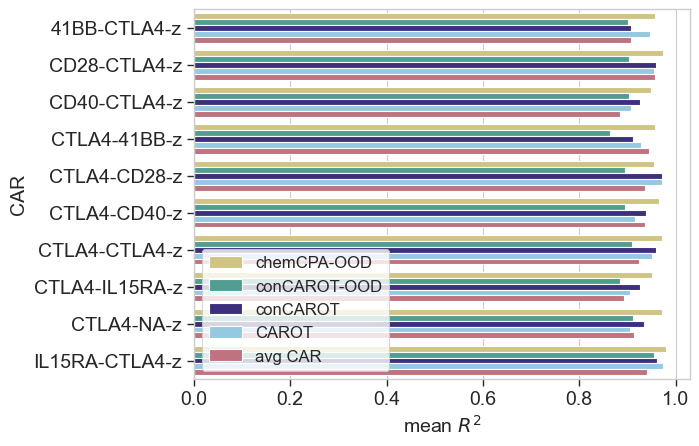

In [19]:
sns.barplot(data=all_scores[all_scores["metric"]=="mean_r2"], y="eval_car", x="score", hue="Model", palette=cond_ood_comp,
           hue_order=["chemCPA-OOD", "conCAROT-OOD", "conCAROT", "CAROT", "avg CAR"])
plt.tick_params(which="both", axis="both", labelsize=14)
plt.xlabel("mean $R^2$", fontsize=14)
plt.ylabel("CAR", fontsize=14)
plt.legend(fontsize=12, loc="lower left")
plt.savefig(f"{base_fig_save}_OOD_results_R2.pdf", bbox_inches="tight")

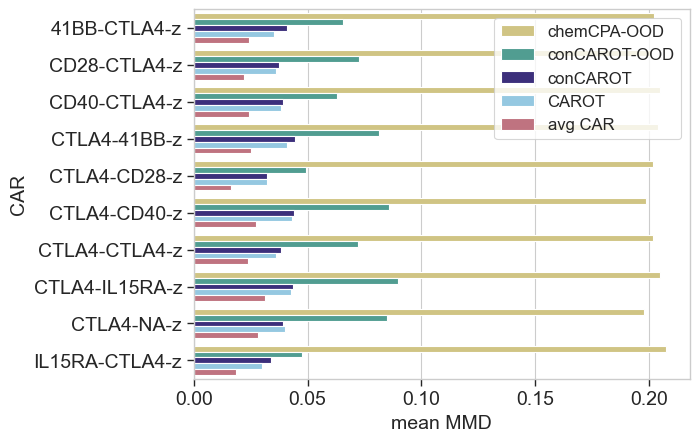

In [20]:
sns.barplot(data=all_scores[all_scores["metric"]=="mean_mmd"], y="eval_car", x="score", hue="Model", palette=cond_ood_comp,
           hue_order=["chemCPA-OOD", "conCAROT-OOD", "conCAROT", "CAROT", "avg CAR"])
plt.tick_params(which="both", axis="both", labelsize=14)
plt.xlabel("mean MMD", fontsize=14)
plt.ylabel("CAR", fontsize=14)
plt.legend(fontsize=12, loc="upper right")
plt.savefig(f"{base_fig_save}_OOD_results_MMD.pdf", bbox_inches="tight")